In [1]:
import re
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from keras import layers, Sequential
from tabulate import tabulate

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, recall_score, precision_score

In [2]:
def download_dataset(name):
    ds = pd.read_csv(name, sep="\t").sample(frac=1).reset_index(drop=True)
    return ds

In [3]:
train_dataset = download_dataset("drugLibTrain_raw.tsv")

In [4]:
test_dataset = download_dataset("drugLibTest_raw.tsv")

In [5]:
def modify_dataset(ds, target):
    ds['benefitsReview'].apply(lambda x: x.lower()) #transform text to lowercase
    ds['benefitsReview'] = ds['benefitsReview'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))

    data = ds[[target,'benefitsReview']]
    tokenizer = Tokenizer(num_words=5000, split=" ")
    tokenizer.fit_on_texts(data['benefitsReview'].values)

    x_tokens = pad_sequences(tokenizer.texts_to_sequences(data['benefitsReview'].values))
    y = pd.get_dummies(data[target]).values

    return x_tokens, y

In [6]:
def get_correct_shape(field):
    match field:
        case "rating":
            return 10
        case "effectiveness":
            return 5
        case "sideEffects":
            return 5

In [7]:
class SAExperiment:
    def __init__(self, model, target, history=None):
        self.model = model(get_correct_shape(target))
        self.target = target
        self.history = history

    def start_experiment(self, batch_size, epochs):
        x_train_tokens, y_train = modify_dataset(train_dataset, self.target)

        self.history = self.model.fit(x_train_tokens,
                                      y_train,
                                      epochs=epochs,
                                      batch_size=batch_size,
                                      verbose=1,
                                      validation_split=0.2,
                                      shuffle=True)

In [8]:
def rnn(shape):
    model = Sequential([
        layers.Embedding(5000, 25),
        layers.SimpleRNN(32),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(shape, activation="softmax")
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
def gru(shape):
    model = Sequential([
        layers.Embedding(5000, 25),
        layers.Bidirectional(layers.GRU(32)),
        layers.Dense(10, activation="relu"),
        layers.Dense(shape, activation="softmax")
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [10]:
def lstm(shape):
    model = Sequential([
        layers.Embedding(5000, 25),
        layers.LSTM(64, return_sequences=False, dropout=0.1, recurrent_dropout=0.1),
        layers.Dense(32, activation="relu"),
        layers.Dense(shape, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
models = [rnn, gru, lstm]
targets = ["rating", "effectiveness", "sideEffects"]
parameters = [models, targets]

SAEs = []
all_SAEs_combinations = list(itertools.product(*parameters))
for p in all_SAEs_combinations:
    SAEs.append(SAExperiment(p[0], p[1]))

In [12]:
def reversed_matrix(matrix):
    rev = []
    for arr in matrix:
        rev.append(np.argmax(arr))
    return rev

In [13]:
def get_scores(mdl, target):
        x_test_tokens, y_test = modify_dataset(test_dataset, target)
        y_pred = mdl.predict(x_test_tokens)

        y_true = reversed_matrix(y_test)
        y_pred_s = reversed_matrix(y_pred)

        accuracy = accuracy_score(y_true, y_pred_s)
        balanced = balanced_accuracy_score(y_true, y_pred_s)
        f1 = f1_score(y_true, y_pred_s, average="micro")
        roc = roc_auc_score(y_test, y_pred)
        recall = recall_score(y_true, y_pred_s, average="micro")
        precision = precision_score(y_true, y_pred_s, average="micro")

        return [accuracy, balanced, f1, roc, recall, precision]

In [14]:
def build_learning_curves(model_history):
    acc = model_history.history["accuracy"]
    val_acc = model_history.history["val_accuracy"]

    loss = model_history.history["loss"]
    loss_acc = model_history.history["val_loss"]

    run_epochs = len(loss)

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(run_epochs), acc, label="Training Accuracy")
    plt.plot(range(run_epochs), val_acc, label="Validation Accuracy")
    plt.legend(loc="lower center")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(range(run_epochs), loss, label="Training Loss")
    plt.plot(range(run_epochs), loss_acc, label="Validation Loss")
    plt.legend(loc="lower center")
    plt.title("Training and Validation Loss")
    plt.show()

In [15]:
BATCH_SIZE = 32
EPOCHS = 10
i = 0
for sae in SAEs:
    print(f"{i + 1}: {all_SAEs_combinations[i][0].__name__} + {sae.target}")
    sae.start_experiment(BATCH_SIZE, EPOCHS)
    i += 1

1: rnn + rating
Epoch 1/10
78/78 [==============================] - 67s 824ms/step - loss: 2.1529 - accuracy: 0.2153 - val_loss: 2.0286 - val_accuracy: 0.2830
Epoch 2/10
78/78 [==============================] - 65s 830ms/step - loss: 2.0414 - accuracy: 0.2563 - val_loss: 2.0000 - val_accuracy: 0.2830
Epoch 3/10
78/78 [==============================] - 65s 828ms/step - loss: 1.9336 - accuracy: 0.2990 - val_loss: 1.9743 - val_accuracy: 0.2347
Epoch 4/10
78/78 [==============================] - 65s 836ms/step - loss: 1.6946 - accuracy: 0.4221 - val_loss: 2.0385 - val_accuracy: 0.2106
Epoch 5/10
78/78 [==============================] - 65s 830ms/step - loss: 1.2667 - accuracy: 0.5714 - val_loss: 2.3000 - val_accuracy: 0.2251
Epoch 6/10
78/78 [==============================] - 65s 836ms/step - loss: 0.8724 - accuracy: 0.7082 - val_loss: 2.8208 - val_accuracy: 0.2138
Epoch 7/10
78/78 [==============================] - 64s 823ms/step - loss: 0.5819 - accuracy: 0.8149 - val_loss: 3.2790 - val_

In [16]:
data, i = [], 0
for sae in SAEs:
    # print(iterator)
    rnn_name = f"{i + 1}: {all_SAEs_combinations[i][0].__name__} + {sae.target}"
    metrics = [rnn_name]
    metrics += get_scores(sae.model, sae.target)
    data.append(metrics)
    i += 1


#define header names
col_names = ["NAME", "Accuracy", "Balanced", "F1", "ROC-AUC", "Recall", "Precision"]

print(tabulate(data, headers=col_names, tablefmt="grid"))

+-------------------------+------------+------------+----------+-----------+----------+-------------+
| NAME                    |   Accuracy |   Balanced |       F1 |   ROC-AUC |   Recall |   Precision |
+=========================+============+============+==========+===========+==========+=============+
| 1: rnn + rating         |   0.155405 |   0.116697 | 0.155405 |  0.532522 | 0.155405 |    0.155405 |
+-------------------------+------------+------------+----------+-----------+----------+-------------+
| 2: rnn + effectiveness  |   0.277992 |   0.205487 | 0.277992 |  0.536103 | 0.277992 |    0.277992 |
+-------------------------+------------+------------+----------+-----------+----------+-------------+
| 3: rnn + sideEffects    |   0.245174 |   0.20353  | 0.245174 |  0.532513 | 0.245174 |    0.245174 |
+-------------------------+------------+------------+----------+-----------+----------+-------------+
| 4: gru + rating         |   0.156371 |   0.101244 | 0.156371 |  0.513119 | 0.156

In [39]:
def learning_curves_template(pltt, data, metric):
    pltt.plot(data.history.history[metric])
    pltt.plot(data.history.history[f"val_{metric}"])
    pltt.set_title(metric + f" ({data.target})", fontstyle="italic")
    pltt.legend(["train", "test"], loc="upper right")
    if metric == "accuracy":
        pltt.set_facecolor("#C5FAD5")
    else:
        pltt.set_facecolor("#FFFFD2")
        pltt.grid(c="#989ea6")

In [44]:
def build_learning_curves_family(saes_fam):
    with plt.style.context("seaborn-darkgrid"):
        fig, axes = plt.subplots(3, 6, figsize=(25,13))
        counter = 0
        for i in range(3):
            for j in range(0, 6, 2):
                learning_curves_template(axes[i, j], saes_fam[counter], "accuracy")
                learning_curves_template(axes[i, j + 1], saes_fam[counter], "loss")
                counter += 1

    plt.setp(axes[-1, :], xlabel="epoch")
    plt.setp(axes[::, 0], ylabel="GRU")
    plt.setp(axes[::2, 0], ylabel="LSTM")
    plt.setp(axes[::3, 0], ylabel="RNN")
    plt.show()

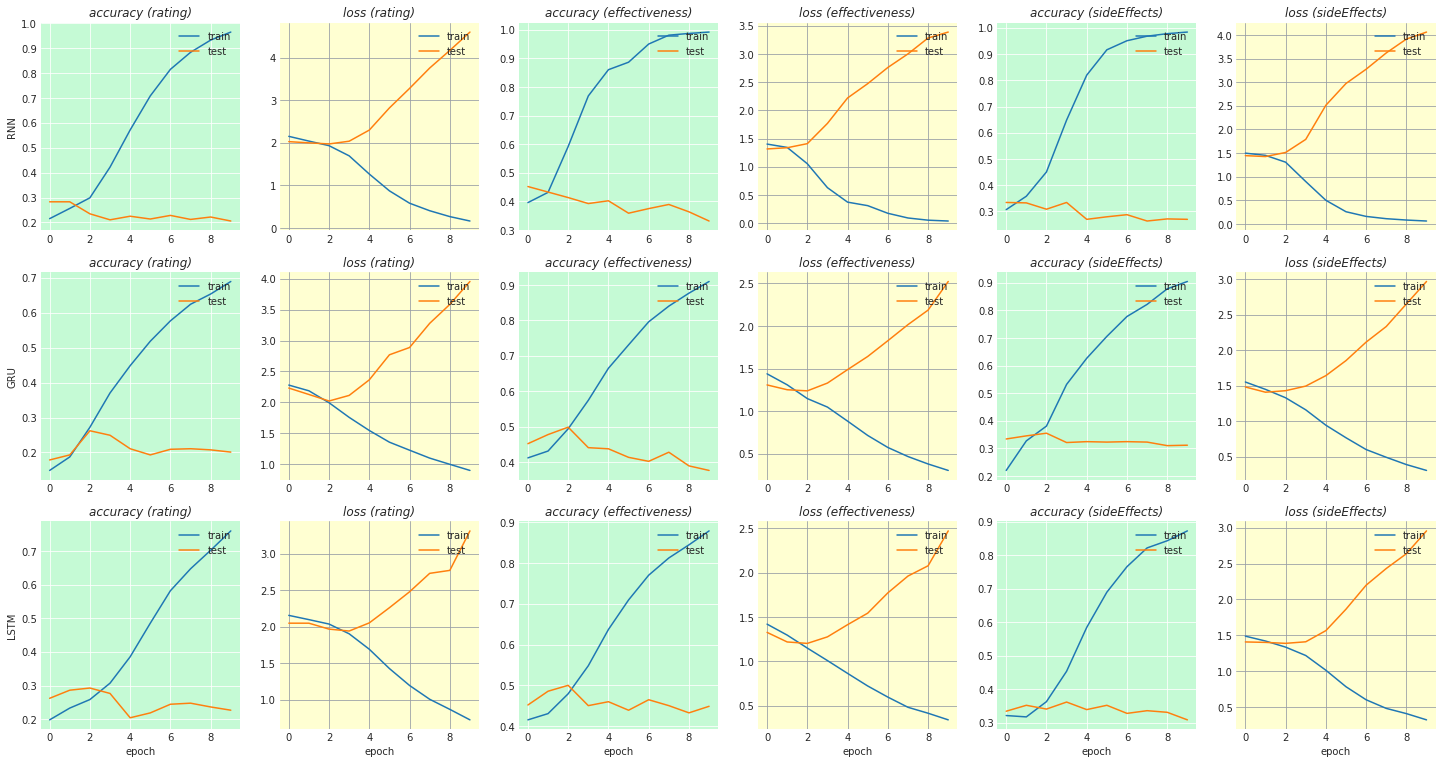

In [45]:
build_learning_curves_family(SAEs)